## Remake Duck model in HydroMT

In [24]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import path
import time
import xarray as xr
import xugrid as xu

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

from hydromt.log import setuplog

In [25]:
!hydromt --version

HydroMT version: 0.9.4


#### Continue with building a QuadTree model

In [26]:
logger = setuplog("sfincs_duck_hydromt", log_level=10)
sf_qt = SfincsModel(data_libs=["deltares_data"], root="test_duck", mode="w+", logger=logger)

2024-03-01 17:42:32,119 - sfincs_duck_hydromt - log - INFO - HydroMT version: 0.9.4
2024-03-01 17:42:33,031 - sfincs_duck_hydromt - data_catalog - INFO - Reading data catalog deltares_data v2024.1.30
2024-03-01 17:42:33,033 - sfincs_duck_hydromt - data_catalog - INFO - Parsing data catalog from https://raw.githubusercontent.com/Deltares/hydromt/main/data/catalogs/deltares_data.yml
2024-03-01 17:42:35,858 - sfincs_duck_hydromt - log - DEBUG - Appending log messages to file d:\repos\hydromt_sfincs\hydromt_sfincs\examples\test_duck\hydromt.log.
2024-03-01 17:42:35,860 - sfincs_duck_hydromt - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


In [27]:
# first have reg grid
sf_qt.setup_grid(
    x0=-2.5,
    y0=-2.5,
    dx=5.0,
    dy=5.0,
    nmax=142,
    mmax=178,
    rotation=0,
    epsg=32620,
)

In [28]:
file_name = r".\input_duck\refine.pol"

refine_gdf = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf_qt.crs)

gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1,]},
    geometry=[
        refine_gdf.unary_union,
    ],
    crs=sf_qt.crs,
)
    
gdf_refinement



,refinement_level,geometry
0,1,"POLYGON ((500.000 702.500, 1000.000 702.500, 1..."


In [29]:
sf_qt.setup_grid(
    # x0=-2.5,
    # y0=-2.5,
    x0=-5,
    y0=-5,    
    dx=10.0,
    dy=10.0,
    nmax=71,
    mmax=89,
    rotation=0,
    epsg=32620,
    refinement_polygons=gdf_refinement,
)

# alternative way of creating a quadtree grid
# sf_qt.setup_grid_from_region(region={"geom": sf.region}, #area that needs to be covered by the grid
#                             res=50, # set resolution
#                             rotated=True, # when True, rotation is determined to minimize the grid extent
#                             refinement_polygons=gdf_refinement)

# NOTE this grid is smaller since the inactive cells of the regular model are already excluded from the grid

Building mesh ...
Refining ...
Time elapsed : 0.03510594367980957 s
Finding neighbors ...
Time elapsed : 0.005999326705932617 s
Setting neighbors left and below ...
Time elapsed : 0.01651310920715332 s
Getting uv points ...
Time elapsed : 0.10984563827514648 s
Making XUGrid ...
Got rid of duplicates in 0.3860 seconds
Made XUGrid in 0.0037 seconds
Time elapsed : 0.742673397064209 s


Generate topobathy on the quadtree grid

In [30]:
# sf_qt.quadtree.data["grid"].ugrid.plot()

sf_qt.quadtree.data

<xarray.Dataset> Size: 819kB
Dimensions:        (mesh2d_nFaces: 14626)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 117kB 0 1 2 3 ... 14623 14624 14625
Data variables: (12/16)
    crs            int32 4B 32620
    level          (mesh2d_nFaces) int32 59kB 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    n              (mesh2d_nFaces) int32 59kB 1 2 3 4 5 ... 138 139 140 141 142
    m              (mesh2d_nFaces) int32 59kB 1 1 1 1 1 ... 178 178 178 178 178
    mu             (mesh2d_nFaces) int8 15kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    mu1            (mesh2d_nFaces) int32 59kB 72 73 74 75 76 77 ... 0 0 0 0 0 0
    ...             ...
    nu             (mesh2d_nFaces) int8 15kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    nu1            (mesh2d_nFaces) int32 59kB 2 3 4 5 6 ... 14624 14625 14626 0
    nu2            (mesh2d_nFaces) int32 59kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    nd             (mesh2d_nFaces) int8 15kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    nd1            (mesh2d_nFaces) int32 59kB 0 1 2 3 ... 14623 14624 14625
    nd2            (mesh2d_nFaces) int32 59kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    x0:         -5
    y0:         -5
    nmax:       71
    mmax:       89
    dx:         10.0
    dy:         10.0
    rotation:   0
    nr_levels:  2

In [31]:
# # depin = r'd:\repos\phd_waves\paper_IG_parametrisation\05_application_case\Duck_NC\01_modelsetup\delilah.nc'
# depin = r'.\input_duck\delilah.nc'

# ds = xr.open_dataset(depin)
 
# # ds has dimensions (n,m) but actually coordinates (x,y) which are now saved as data vars; change this
# ds = ds.rename({"x":"xc","y":"yc","zb":"elevtn"})

# ds = ds.set_coords(["xc","yc"])
 
# # drop coordinates that are not used
# ds = ds.drop(["n","m"])
 
#  # rename the dims
# ds = ds.rename({"n":"x","m":"y"})

# ds["elevtn"].plot()
 
# # add crs to the dataset
# ds = ds.assign_attrs({"crs":"EPSG:32620"})

# from hydromt import DataCatalog
 
# dc = DataCatalog()
# da = dc.get_rasterdataset(ds)

In [32]:
# da.raster.set_crs(32620)
# da.raster.crs

In [33]:
depin = r'.\input_duck\delilah.tif'
da = dc.get_rasterdataset(depin)

da

<xarray.DataArray 'delilah' (y: 71, x: 178)> Size: 101kB
dask.array<getitem, shape=(71, 178), dtype=float64, chunksize=(71, 178), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1kB 0.0 5.0 10.0 15.0 ... 870.0 875.0 880.0 885.0
  * y            (y) float64 568B 0.0 10.0 20.0 30.0 ... 670.0 680.0 690.0 700.0
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    source_file:    delilah.tif

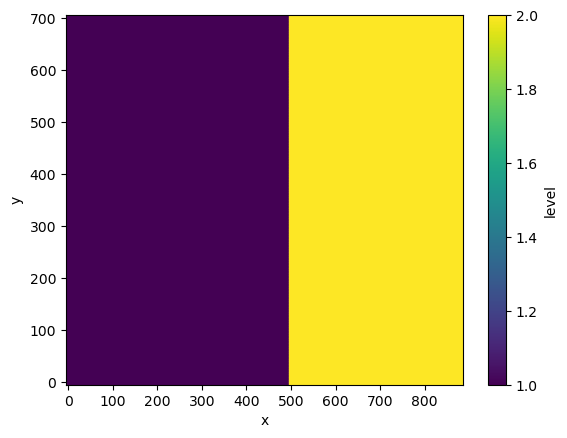

In [34]:
sf_qt.quadtree.data["level"].ugrid.plot()

In [35]:
# datasets_dep = [{"da": da}]#, 
# datasets_dep = [{"elevtn": "gebco"}] #works
datasets_dep = [{"elevtn":depin}]

sf_qt.setup_dep(datasets_dep=datasets_dep)

2024-03-01 17:42:39,435 - sfincs_duck_hydromt - rasterdataset - INFO - Reading  raster data from .\input_duck\delilah.tif
2024-03-01 17:42:39,536 - sfincs_duck_hydromt - rasterdataset - DEBUG - Clip to [-5.003, -5.000, 885.003, 705.008] (epsg:32620))


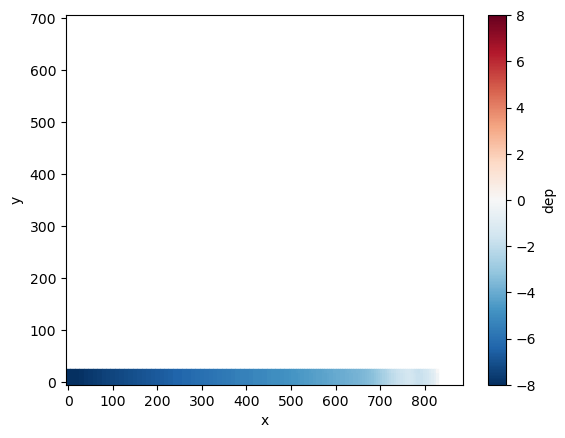

In [36]:
sf_qt.quadtree.data["dep"].ugrid.plot()

# sf_qt.grid['dep'].plot()


Continue with the mask for the QuadTree grid; we aim to have the same active extent as the regular grid in different ways:
- Based on elevation
- Bu using an include polygon

In [37]:
# sf_qt.quadtree.setup_mask(include_polygon=mask_include, open_boundary_polygon=open_include, open_boundary_zmax=-3)
sf_qt.quadtree.setup_mask_active(zmin=-999, zmax=999)
# sf_qt.setup_mask_active(zmin=-999, zmax=999)

In [38]:
#NOTE we lose performance through the SfincsModel, I expect this to come from the data_catalog that parses the geodataframes
# sf_qt.quadtree.setup_mask_active(gdf_include=mask_include, all_touched=False)

In [39]:
sf_qt.crs

<Projected CRS: EPSG:32620>
Name: WGS 84 / UTM zone 20N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 66°W and 60°W, northern hemisphere between equator and 84°N, onshore and offshore. Anguilla. Antigua and Barbuda. Bermuda. Brazil. British Virgin Islands. Canada - New Brunswick; Labrador; Nova Scotia; Nunavut; Prince Edward Island; Quebec. Dominica. Greenland. Grenada. Guadeloupe. Guyana. Martinique. Montserrat. Puerto Rico. St Kitts and Nevis. St Barthelemy. St Lucia. St Maarten, St Martin. St Vincent and the Grenadines. Trinidad and Tobago. Venezuela. US Virgin Islands.
- bounds: (-66.0, 0.0, -60.0, 84.0)
Coordinate Operation:
- name: UTM zone 20N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
file_name = r'./input_duck/bnd_wl_delilah_Left.pol'
# file_name = r"d:\repos\hydromt_sfincs\hydromt_sfincs\examples\input_duck\bnd_wl_delilah_Left.pol"

open_include = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf_qt.crs)


2024-03-01 17:43:25,544 - sfincs_duck_hydromt - geodataframe - DEBUG - Clip intersects [-67.489, -0.000, -67.481, 0.006] (EPSG:4326)


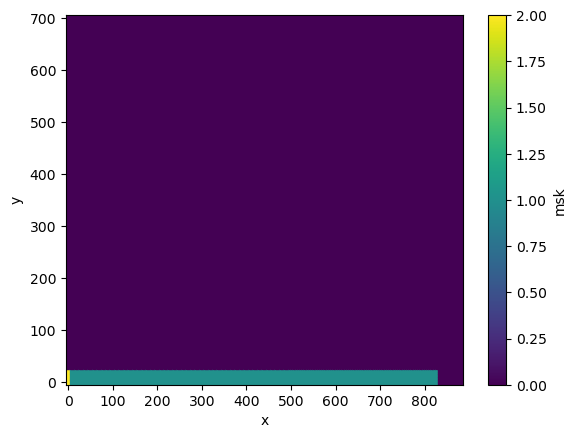

In [42]:
sf_qt.setup_mask_bounds(btype="waterlevel", zmax=0, include_mask=open_include) #

# sf_qt.grid['msk'].plot(x="x", y="y")
sf_qt.quadtree.data["msk"].ugrid.plot()


In [ ]:
# plot the difference between the mask (original code) and the msk (new code)
# NOTE with all_touched=True, there is a small difference
# (sf_qt.quadtree.data["mask"]-sf_qt.quadtree.data["msk"]).ugrid.plot()

In [ ]:
# drop the mask variable from the quadtree data
# sf_qt.quadtree.data = sf_qt.quadtree.data.drop("mask")

## Now some snapwave functionalities

2024-03-01 17:43:53,242 - sfincs_duck_hydromt - quadtree - INFO - Building mask ...
2024-03-01 17:43:53,243 - sfincs_duck_hydromt - quadtree - INFO - Build new mask for: snapwave ...


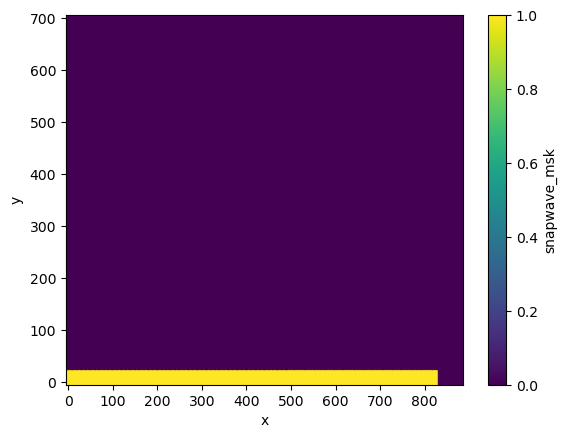

In [43]:
sf_qt.setup_mask_active(model="snapwave", zmin=-999, zmax=1)#, include_mask=gdf_riv_buf)
# sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()

sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()


Try situation where we want to directly copy the SFINCS mask to SnapWave:

2024-03-01 17:45:55,732 - sfincs_duck_hydromt - quadtree - INFO - Using SFINCS mask for SnapWave mask ...


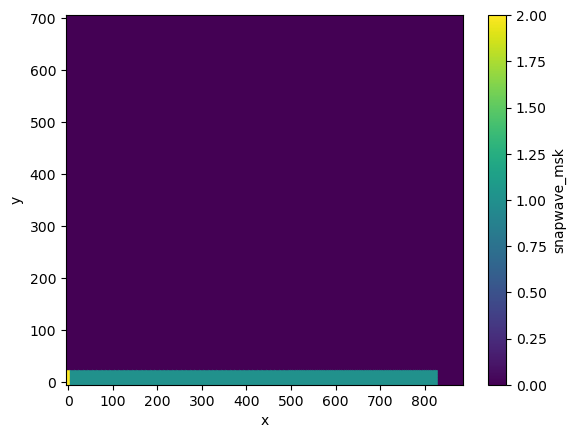

In [45]:
# file_name = r'./input_duck/snapwave_include_delilah_3.pol'
# open_include = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf_qt.crs)

sf_qt.setup_mask_bounds(model="snapwave", copy_sfincsmask=True)#, include_mask=open_include)
sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()

In [46]:
sf_qt.quadtree.data

<xarray.Dataset> Size: 965kB
Dimensions:        (mesh2d_nFaces: 14626)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 117kB 0 1 2 3 ... 14623 14624 14625
Data variables: (12/19)
    crs            int32 4B 32620
    level          (mesh2d_nFaces) int32 59kB 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    n              (mesh2d_nFaces) int32 59kB 1 2 3 4 5 ... 138 139 140 141 142
    m              (mesh2d_nFaces) int32 59kB 1 1 1 1 1 ... 178 178 178 178 178
    mu             (mesh2d_nFaces) int8 15kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    mu1            (mesh2d_nFaces) int32 59kB 72 73 74 75 76 77 ... 0 0 0 0 0 0
    ...             ...
    nd             (mesh2d_nFaces) int8 15kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    nd1            (mesh2d_nFaces) int32 59kB 0 1 2 3 ... 14623 14624 14625
    nd2            (mesh2d_nFaces) int32 59kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    dep            (mesh2d_nFaces) float64 117kB dask.array<chunksize=(14626,), meta=np.ndarray>
    msk            (mesh2d_nFaces) uint8 15kB 2 2 2 0 0 0 0 0 ... 0 0 0 0 0 0 0
    snapwave_msk   (mesh2d_nFaces) uint8 15kB 2 2 2 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    x0:         -5
    y0:         -5
    nmax:       71
    mmax:       89
    dx:         10.0
    dy:         10.0
    rotation:   0
    nr_levels:  2

### Now create a subgrid table for this model

In [47]:
# sf_qt.setup_subgrid(datasets_dep=datasets_dep, buffer_cells=40)

2024-03-01 17:46:12,408 - sfincs_duck_hydromt - rasterdataset - INFO - Reading  raster data from .\input_duck\delilah.tif
2024-03-01 17:46:12,530 - sfincs_duck_hydromt - rasterdataset - DEBUG - Clip to [-5.003, -5.000, 885.003, 705.008] (epsg:32620))
2024-03-01 17:46:12,678 - sfincs_duck_hydromt - subgrid - INFO - Processing level 1 of 2 ...
2024-03-01 17:46:12,681 - sfincs_duck_hydromt - subgrid - INFO - Number of regular cells in a block : 100
2024-03-01 17:46:12,683 - sfincs_duck_hydromt - subgrid - INFO - Number of blocks in n direction    : 1
2024-03-01 17:46:12,684 - sfincs_duck_hydromt - subgrid - INFO - Number of blocks in m direction    : 1
2024-03-01 17:46:12,687 - sfincs_duck_hydromt - subgrid - INFO - Grid size of flux grid             : dx= 10.0, dy= 10.0
2024-03-01 17:46:12,689 - sfincs_duck_hydromt - subgrid - INFO - Grid size of subgrid pixels        : dx= 0.5, dy= 0.5
2024-03-01 17:46:12,691 - sfincs_duck_hydromt - subgrid - DEBUG - Processing block 1 of 1 ...
2024-03-

### Add some random boundary conditions

In [ ]:
# x&y-locations in same coordinate reference system as the grid:
x = [319526, 329195]
y = [5041108, 5046243]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

# In this case we will provide 3 values (periods=3) between the start (tstart=20100201 000000) and the end (tstop=20100201 120000) of the simulation:
time = pd.date_range(
    start=utils.parse_datetime(sf.config["tstart"]),
    end=utils.parse_datetime(sf.config["tstop"]),
    periods=3,
)

# add some water levels
bzs = [[0, 0.25], [0.75, 1.0], [0, 0.25]]

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)

# Actually add it to the SFINCS model class:
sf_qt.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)


In [ ]:
# We now use the previously created src discharge points for the regular model
gdf = sf.forcing["dis"].vector.to_gdf()

# make up some discharge data
index = sf.forcing["dis"].index
dis = np.array([[2.0, 1.0], [5.0, 2.0], [2.0, 1.0]])
dispd = pd.DataFrame(index=time, columns=index, data=dis)

# now we call the function setup_discharge_forcing, which adds the discharge forcing to the src points
sf_qt.setup_discharge_forcing(timeseries=dispd, locations=gdf)

# # NOTE: the discharge forcing data is now stored in the sf.forcing dictionary
sf_qt.forcing.keys()

### And save everything we build sofar

In [ ]:
sf_qt.config["tspinup"] = 3600
sf_qt.config["alpha"] = 0.5

In [ ]:
sf_qt.write()

Run and read results, make plots and animation

In [ ]:
import xugrid as xu
uds = xu.open_dataset(r".\test_duck\sfincs_map.nc")

In [ ]:
uds["zb"].ugrid.plot()

In [ ]:
uds["zsmax"].max(dim="timemax").ugrid.plot(vmax=2)

In [ ]:
# plot rough estimation of water depth
h = uds["zsmax"].max(dim="timemax") - uds["zb"]

h = h[h>0.1]

h.ugrid.plot()

In [ ]:
# create zs plot and save to mod.root/figs/sfincs_zs.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
da_zs = uds["zs"]

def update_plot(i, da_zs, cax_zs):
    da_zsi = da_zs.isel(time=i)
    t = da_zsi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water level {t}")
    cax_zs.set_array(da_zsi.values.ravel())

fig, ax = plt.subplots(figsize=(11, 7))
cax_zs = da_zs.isel(time=0).ugrid.plot(
    ax=ax, vmin=0, vmax=3, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_zs.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_zs,
        cax_zs,
    ),
)

# to save to mp4
# ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())

In [ ]:
uds["msk"].where(uds["msk"]==2, np.nan).ugrid.plot()